# Data Mining and Text Mining Challenge 2020

__Tasio Mendez Ayerbe__ <br>
tasio.mendez (@) mail.polimi.it <br>


# 3 Prediction

In this notebook, the best model found on the [previous one](DMTM2020-NB2-Modeling.ipynb) is built and used to predict the sales of the final test set. At the end, a new submission CSV file will be generated with the date, sku and the prediction.

---

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import pandas as pd

# select the style from fivethityeight website
mpl.rcdefaults() 
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

%matplotlib inline
mpl.rcParams['figure.figsize'] = (18, 16)
mpl.rcParams['figure.dpi'] = 80

import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# Cross-validation 10-fold
cv = KFold(n_splits=10, random_state=42, shuffle=True)

# MAPE function scorer
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

As we need to compute lags over the data series, we are going to join both dataframes, the train dataframe and the test one. Thus, we can compute the lags over the test data. We should take into account that the test data starts from 2019-06-22.

In [5]:
raw_train = pd.read_csv('./data/train.csv' ).rename(columns={'Unnamed: 0': 'date'})
raw_test  = pd.read_csv('./data/x_test.csv').rename(columns={'Unnamed: 0': 'date'})

raw = pd.concat([raw_train, raw_test])

df_original = raw.copy()
df_original.date = df_original.date.apply(lambda x: datetime.strptime(x, "WE %d %B %Y"))

print("DataFrame shape (samples x features): ({} x {})".format(df_original.shape[0], df_original.shape[1]))
df_original.tail()

DataFrame shape (samples x features): (6019 x 11)


,date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target
295,2019-11-16,1206,SINGLE,125.65,BRAND4,0.41,19.0,98.800841,111353.0,1,NaN
296,2019-11-23,1206,SINGLE,125.65,BRAND4,0.57,2.0,99.129248,63359.0,1,NaN
297,2019-11-30,1206,SINGLE,125.65,BRAND4,0.57,0.0,28.696578,35238.0,1,NaN
298,2019-12-07,1206,SINGLE,125.65,BRAND4,0.56,2.0,18.972899,34242.0,1,NaN
299,2019-12-14,1206,SINGLE,125.65,BRAND4,0.56,6.0,29.153580,37889.0,1,NaN


In [6]:
def lag_dataframe(df, num_lags):
    acc = pd.DataFrame()
    for sku in df.sku.unique():
        aux = df[df.sku == sku]
        for lag in range(1, num_lags):
            aux['sales w-{}'.format(lag + 1)] = aux['sales w-1'].shift(lag)
        acc = acc.append(aux)

    return acc

In [7]:
df = lag_dataframe(df_original, 4)

print("DataFrame shape (samples x features): ({} x {})".format(df.shape[0], df.shape[1]))
df.head()

DataFrame shape (samples x features): (6019 x 14)


,date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target,sales w-2,sales w-3,sales w-4
0,2016-12-10,2689,SINGLE,395.41,BRAND1,1.16,NaN,NaN,NaN,0,24175.0,NaN,NaN,NaN
1,2016-12-17,2689,SINGLE,395.41,BRAND1,1.15,1.0,17.676112,24175.0,0,23521.0,NaN,NaN,NaN
2,2016-12-24,2689,SINGLE,395.41,BRAND1,1.16,1.0,24.482803,23521.0,0,22075.0,24175.0,NaN,NaN
3,2016-12-31,2689,SINGLE,395.41,BRAND1,1.16,0.0,19.410646,22075.0,0,16492.0,23521.0,24175.0,NaN
4,2017-01-07,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0,25971.0,22075.0,23521.0,24175.0


In [8]:
encoder = OneHotEncoder()
pack_enc = encoder.fit_transform(df[['pack']])

df = df.join(pd.DataFrame(pack_enc.toarray(), columns=['pack_multi', 'pack_single']))
df = df.drop('pack', axis=1)

df = df.set_index('date')
df = df[~df['sales w-4'].isna()]

In [9]:
no_features = ['sku', 'pack', 'brand', 'scope', 'target']

X_train = df['2016':'2019-06-23'][df.columns.difference(no_features)]
y_train = df['2016':'2019-06-23'].target

X_test = df['2019-06-23':'2020'][df.columns.difference(no_features)]

In [10]:
model = RandomForestRegressor(n_estimators=280, random_state=42)

Once we have prepared the data, we can build the model and train it with the corresponding features. As it can be noticed, the MAPE error for the model using cross-validation is of <span style="border: 1px solid green; padding: 0px 5px; border-radius: 10px; margin: 0px 3px;"> 9.8910 </span>.

In [11]:
scores = np.abs(cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer))
print("MAPE Random Forest: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

MAPE Random Forest: 9.8910 (+/- 1.6999)


In [12]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=280, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [13]:
y_pred = model.predict(df[df.columns.difference(no_features)])

In [14]:
df['prediction'] = y_pred
df = df.astype({ 'prediction': int })
df.head()

,sku,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target,sales w-2,sales w-3,sales w-4,pack_multi,pack_single,prediction
date,,,,,,,,,,,,,,,
2019-06-29,1027,114.23,BRAND2,0.56,10.0,24.386541,66337.0,1,NaN,71405.0,69399.0,58193.0,0.0,1.0,63453
2019-07-06,1027,114.23,BRAND2,0.55,4.0,37.437842,49992.0,1,NaN,66337.0,71405.0,69399.0,0.0,1.0,55117
2019-07-13,1027,114.23,BRAND2,0.45,0.0,28.039623,58062.0,1,NaN,49992.0,66337.0,71405.0,0.0,1.0,82907
2019-07-20,1027,114.23,BRAND2,0.50,19.0,100.000000,90908.0,1,NaN,58062.0,49992.0,66337.0,0.0,1.0,79521
2017-01-07,2689,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0,25971.0,22075.0,23521.0,24175.0,0.0,1.0,24351


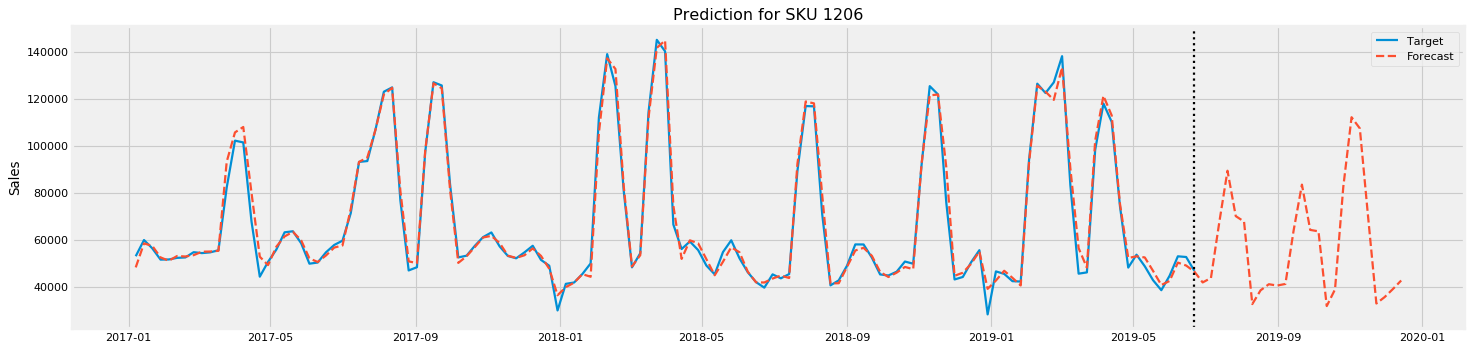

In [15]:
f, axes = plt.subplots(1, 1, figsize=(20, 5))

sns.lineplot(x='date', y='target', data=df[df.sku==1206].reset_index(), ax=axes)
axes.lines[0].set_label("Target")
sns.lineplot(x='date', y='prediction', data=df[df.sku==1206].reset_index(), ax=axes)
axes.lines[1].set_linestyle("--")
axes.lines[1].set_label("Forecast")
plt.axvline(datetime(2019, 6, 22), c='black', linestyle=':')
plt.title('Prediction for SKU 1206')
plt.ylabel('Sales')
plt.xlabel('')
plt.legend()
plt.show()

In the plot above, we have plotted the sales for a given SKU. We can notice that the blue line are the target sales, data used to train the model, while the red dashed line is the prediction for the given SKU. 

In [16]:
# Export predicted data to ./data/submission.csv
df['2019-06-23':][['sku', 'prediction']].to_csv('./data/submission.csv')